In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import src
from cartopy import crs as ccrs
import cartopy
import typhon as ty
from ac3airborne.tools import flightphase
import warnings

# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/typhon/nonlte/rtc/__init__.py:9: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def FOSC(tau, Sb, Sm, Ib):


In [2]:
p5_ACLOUD = xr.open_dataset('/home/mringel/lwp_project/mringel/data/lwp_retrieved/ACLOUD_allRFs_P5_lwp_v4.nc')
p5_AFLUX = xr.open_dataset('/home/mringel/lwp_project/mringel/data/lwp_retrieved/AFLUX_allRFs_P5_lwp_v4.nc')
p5_MOSAiC = xr.open_dataset('/home/mringel/lwp_project/mringel/data/lwp_retrieved/MOSAiC-ACA_allRFs_P5_lwp_v4.nc')
p5_HALOAC3 = xr.open_dataset('/home/mringel/lwp_project/mringel/data/lwp_retrieved/HALO-AC3_allRFs_P5_lwp_v4.nc')

datasets = [p5_ACLOUD,p5_AFLUX,p5_MOSAiC,p5_HALOAC3]

In [3]:
sic_avg_aflux = xr.open_dataset('/data/obs/campaigns/aflux/auxiliary/sea_ice/avg/AFLUX_mean_sic_asi-AMSR2-n6250-v5.4.nc')
sic_avg_acloud = xr.open_dataset('/data/obs/campaigns/acloud/auxiliary/sea_ice/avg/ACLOUD_mean_sic_asi-AMSR2-n6250-v5.4.nc')
sic_avg_mosaicaca = xr.open_dataset('/data/obs/campaigns/mosaic-aca/auxiliary/sea_ice/avg/MOSAiC-ACA_mean_sic_asi-AMSR2-n6250-v5.4.nc')
sic_avg_haloac3 = xr.open_dataset('/data/obs/campaigns/halo-ac3/auxiliary/sea_ice/avg/HALO-AC3_mean_sic_asi-AMSR2-n6250-v5.4.nc')

sic_datasets = [sic_avg_acloud,sic_avg_aflux,sic_avg_mosaicaca,sic_avg_haloac3]

Text(0.33, 1.05, 'HALO-AC3')

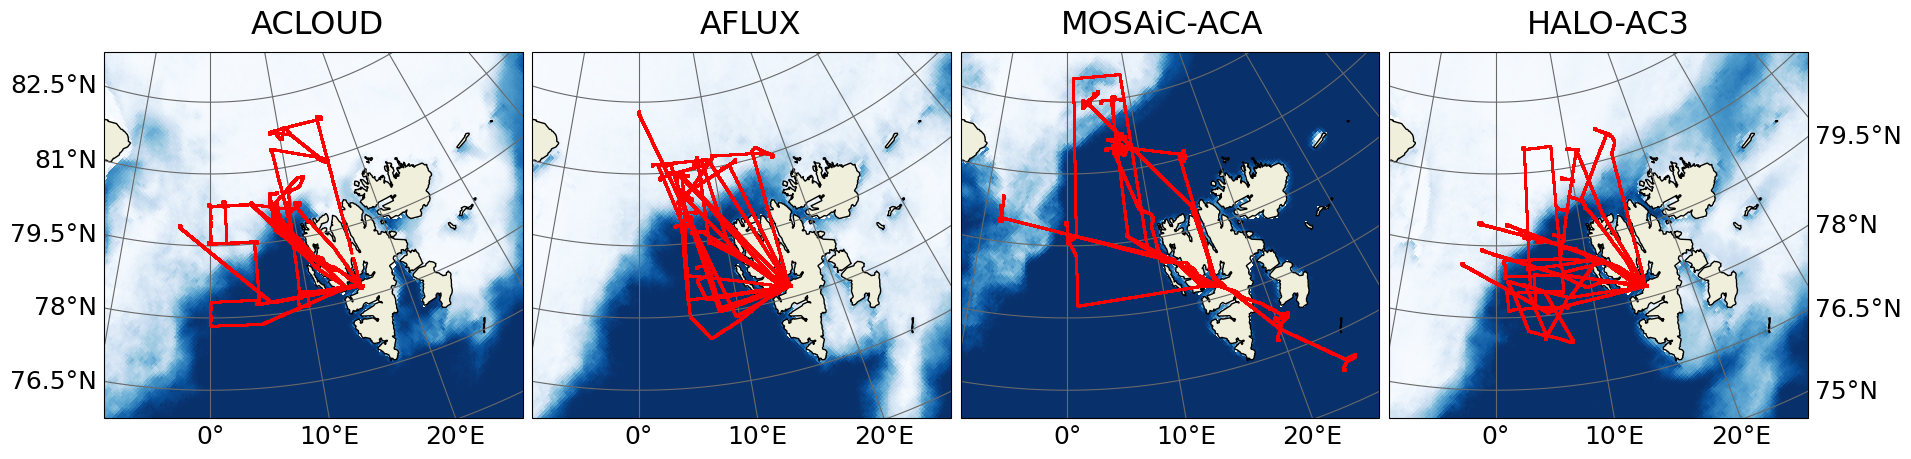

In [4]:
fig, axs = plt.subplots(nrows=1,ncols=4,figsize=(19,5),sharey=True,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()})

labels = ['ACLOUD','AFLUX','MOSAiC-ACA','HALO-AC3']

for col,dataset in enumerate(datasets):

    # set map extent
    axs[col].set_extent([-9., 27.25, 75.75, 82.75], crs=ccrs.PlateCarree())

    # plot sea-ice concentration
    axs[col].pcolormesh(
        sic_datasets[col].lon,sic_datasets[col].lat,sic_datasets[col].sic,
        cmap='Blues_r',
        transform=ccrs.PlateCarree())

    # plot land features
    axs[col].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')

    # plot gridlines & labels
    gl = axs[col].gridlines(color='dimgray',draw_labels=True,
                            x_inline=False, y_inline=False,
                            zorder=1,transform=ccrs.PlateCarree())
    gl.rotate_labels = False

    if col == 0:
        gl.right_labels = False
        gl.top_labels = False
    if col in [1,2]:
        gl.right_labels = False
        gl.left_labels = False
        gl.top_labels = False
    if col == 3:
        gl.left_labels = False
        gl.top_labels = False
    
    gl.xlabel_style={'size': 18}
    gl.ylabel_style={'size': 18}

    # plot P5 coordinates
    axs[col].scatter(dataset.lon,dataset.lat,
                     color='red',
                     #label='P5 tracks',
                     #alpha=0.15,
                     s=0.5,
                     zorder=2,
                     transform=ccrs.PlateCarree())
        
axs[0].text(0.35,1.05,labels[0],fontsize=23,transform=axs[0].transAxes)
axs[1].text(0.4,1.05,labels[1],fontsize=23,transform=axs[1].transAxes)
axs[2].text(0.24,1.05,labels[2],fontsize=23,transform=axs[2].transAxes)
axs[3].text(0.33,1.05,labels[3],fontsize=23,transform=axs[3].transAxes)

#plt.savefig('/home/mringel/lwp_project/figures/figures4paper/maps_of_flights.png',
#            bbox_inches='tight',
#            dpi=200)

ACLOUD: 111037
ACLOUD high levels: 17237
AFLUX: 167556
AFLUX high levels: 20189
MOSAiC-ACA: 122933
MOSAiC-ACA high levels: 35501
HALO-AC3: 165509
HALO-AC3 high levels: 71650


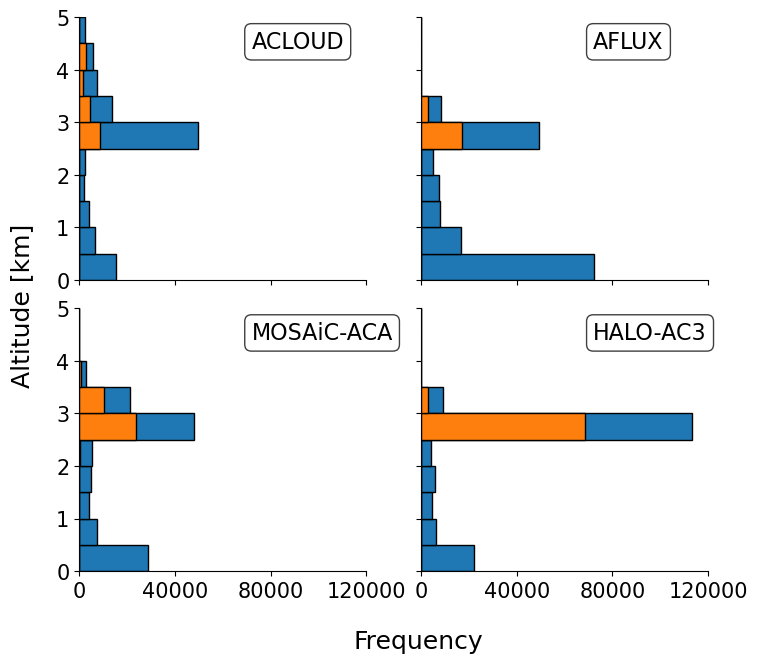

In [16]:
fig, axs = plt.subplots(2,2,figsize=(7,6),sharex=True,sharey=True)
warnings.simplefilter("ignore")

cat, meta, credentials, kwds = src.get_ac3_meta()

campaigns = list(cat)

del campaigns[1] # PARACIMIP
del campaigns[-1] # HAMAG

for j,campaign in enumerate(campaigns): 
    flight_altitudes = []
    flight_altitudes_high_levels = []
    for flight_id in list(cat[campaign]['P5']['MiRAC-A']):
        if flight_id in ['ACLOUD_P5_RF04','ACLOUD_P5_RF06','ACLOUD_P5_RF11','ACLOUD_P5_RF14','ACLOUD_P5_RF15','ACLOUD_P5_RF16','ACLOUD_P5_RF17',
                         'ACLOUD_P5_RF21','ACLOUD_P5_RF22','ACLOUD_P5_RF23','ACLOUD_P5_RF25','AFLUX_P5_RF09','AFLUX_P5_RF10',
                         'AFLUX_P5_RF11','AFLUX_P5_RF13','MOSAiC-ACA_P5_RF09','HALO-AC3_P5_RF01']: continue
        

        P5 = xr.open_dataset(f'/net/secaire/mringel/data/lwp_retrieved/{flight_id}_lwp_v4.nc')

        RF_GPS = src.get_GPS_along_track(flight_id)
        RF_GPS = RF_GPS.sel(time=P5.time,drop=True)
        flight_altitudes.append(RF_GPS.alt.values/1000)

        P5 = P5.dropna('time')
        P5 = P5.where((P5.si_mask == 0) & (P5.ls_mask == 0),drop = True)

        RF_GPS = RF_GPS.sel(time=P5.time,drop=True)

        flight_altitudes_high_levels.append(RF_GPS.alt.values/1000)
    
    # concatenate all lists within general list to one 1D array
    flight_altitudes_high_levels = np.concatenate(flight_altitudes_high_levels,axis=0)
    flight_altitudes = np.concatenate(flight_altitudes,axis=0)

    print(f'{campaign}: {len(flight_altitudes)}')
    print(f'{campaign} high levels: {len(flight_altitudes_high_levels)}')

    if j == 0:
        col = 0
        row = 0
    if j == 1:
        col = 1
        row = 0
    if j == 2:
        col = 0
        row = 1
    if j == 3:
        col = 1
        row = 1

    #axs[row,col].grid(True)

    axs[row,col].hist(flight_altitudes,bins=10,range=(0,5),ec='black',orientation='horizontal',label='all flight segments')
    axs[row,col].hist(flight_altitudes_high_levels,bins=10,range=(0,5),ec='black',orientation='horizontal',label='high levels')

    axs[row,col].set_xticks([0,40000,80000,120000])

    axs[row,col].ticklabel_format(useOffset=False, style='plain')

    axs[row,col].set_ylim(0,5)

    textbox = dict(boxstyle='round', facecolor='white', alpha=0.75)
    axs[row,col].text(0.6,0.95,campaign,fontsize=16,transform=axs[row,col].transAxes,
              verticalalignment='top', bbox=textbox)
    
fig.text(-0.06, 0.5,'Altitude [km]',rotation=90,fontsize=18,va='center')
fig.text(0.43, -0.06,'Frequency',fontsize=18,va='center')

warnings.simplefilter("always")

plt.savefig('/home/mringel/lwp_project/figures/figures4paper/P5_flight_levels_v2.png',bbox_inches='tight',dpi=200)

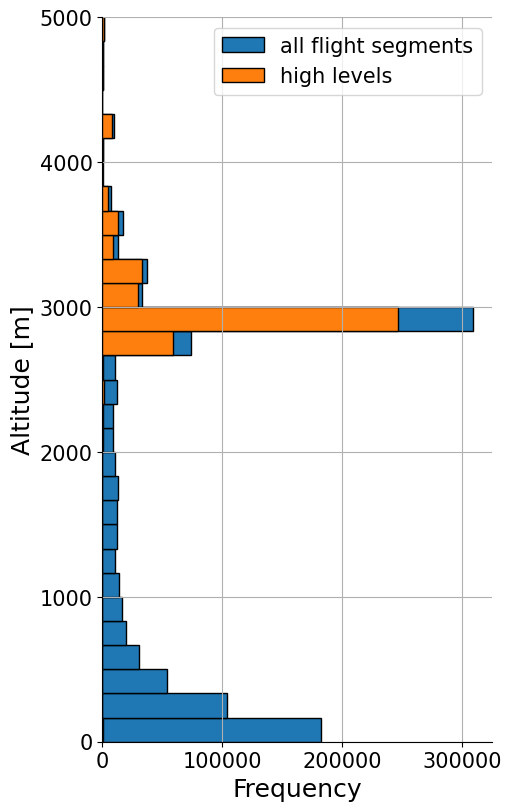

In [66]:
fig, ax = plt.subplots(figsize=(5,8))

ax.grid(True)

ax.hist(flight_altitudes,bins=30,range=(0,5000),ec='black',orientation='horizontal',label='all flight segments')
ax.hist(flight_altitudes_high_levels,bins=30,range=(0,5000),ec='black',orientation='horizontal',label='high levels')

ax.ticklabel_format(useOffset=False, style='plain')

ax.set_ylim(0,5000)
ax.set_ylabel('Altitude [m]')
ax.set_xlabel('Frequency')
ax.legend()

#plt.savefig('/home/mringel/lwp_project/figures/figures4paper/P5_flight_levels.png',bbox_inches='tight',dpi=200)